In [113]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.callbacks import EarlyStopping
import warnings
%matplotlib inline

warnings.simplefilter("ignore")

# Data

In [115]:
data = pd.read_csv("/content/drive/MyDrive/Kaggle/GoodReads_100k_books.csv")

In [116]:
data.head()

,author,bookformat,desc,genre,img,isbn,isbn13,link,pages,rating,reviews,title,totalratings
0,Laurence M. Hauptman,Hardcover,Reveals that several hundred thousand Indians ...,"History,Military History,Civil War,American Hi...",https://i.gr-assets.com/images/S/compressed.ph...,002914180X,9.78E+12,https://goodreads.com/book/show/1001053.Betwee...,0,3.52,5,Between Two Fires: American Indians in the Civ...,33
1,"Charlotte Fiell,Emmanuelle Dirix",Paperback,Fashion Sourcebook - 1920s is the first book i...,"Couture,Fashion,Historical,Art,Nonfiction",https://i.gr-assets.com/images/S/compressed.ph...,1906863482,9.78E+12,https://goodreads.com/book/show/10010552-fashi...,576,4.51,6,Fashion Sourcebook 1920s,41
2,Andy Anderson,Paperback,The seminal history and analysis of the Hungar...,"Politics,History",https://i.gr-assets.com/images/S/compressed.ph...,948984147,9.78E+12,https://goodreads.com/book/show/1001077.Hungar...,124,4.15,2,Hungary 56,26
3,Carlotta R. Anderson,Hardcover,"""All-American Anarchist"" chronicles the life a...","Labor,History",https://i.gr-assets.com/images/S/compressed.ph...,814327079,9.78E+12,https://goodreads.com/book/show/1001079.All_Am...,324,3.83,1,All-American Anarchist: Joseph A. Labadie and ...,6
4,Jean Leveille,NaN,"Aujourdâ€™hui, lâ€™oiseau nous invite Ã sa ta...",NaN,https://i.gr-assets.com/images/S/compressed.ph...,2761920813,NaN,https://goodreads.com/book/show/10010880-les-o...,177,4.00,1,Les oiseaux gourmands,1


In [117]:
data.shape

(100000, 13)

In [118]:
data = data[~(data['totalratings'] < 1000)]
data = data[~(data['pages'] < 100)]

In [119]:
data.reset_index(drop=True)

,author,bookformat,desc,genre,img,isbn,isbn13,link,pages,rating,reviews,title,totalratings
0,Helen Fremont,Paperback,"""To this day, I don't even know what my mother...","Autobiography,Memoir,Nonfiction,World War II,H...",https://i.gr-assets.com/images/S/compressed.ph...,385333706,9.78E+12,https://goodreads.com/book/show/1001282.After_...,368,4.00,328,After Long Silence,2898
1,Christopher Morley,Paperback,"Roger Mifflin is part pixie, part sage, part n...","Fiction,Writing,Books About Books,Classics,Hum...",https://i.gr-assets.com/images/S/compressed.ph...,1414270658,9.78E+12,https://goodreads.com/book/show/1001312.Parnas...,152,4.03,1214,Parnassus on Wheels,6107
2,Robert J. Shiller,Paperback,As Robert Shillerâ€™s new 2009 preface to his ...,"Economics,Economics,Finance,Business,Nonfictio...",https://i.gr-assets.com/images/S/compressed.ph...,767923634,9.78E+12,https://goodreads.com/book/show/100132.Irratio...,304,3.98,275,Irrational Exuberance,7019
3,"Ovid,David Malouf,James Michie",Paperback,NaN,"Poetry,Classics,Nonfiction,Philosophy,Romance,...",https://i.gr-assets.com/images/S/compressed.ph...,375761179,9.78E+12,https://goodreads.com/book/show/100142.The_Art...,199,3.81,349,The Art of Love,5154
4,Joseph Staten,Paperback,"This is how it began...,It is the year 2524. H...","Science Fiction,Fiction,Games,Video Games,Spor...",https://i.gr-assets.com/images/S/compressed.ph...,765315696,9.78E+12,https://goodreads.com/book/show/1001442.Halo,396,3.98,271,Halo: Contact Harvest,8033
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19374,Robert Jay Lifton,Paperback,Nazi doctors did more than conduct bizarre exp...,"History,Nonfiction,Psychology,World War II,Hol...",https://i.gr-assets.com/images/S/compressed.ph...,465049052,9.78047E+12,https://goodreads.com/book/show/173187.The_Naz...,561,4.10,118,The Nazi Doctors: Medical Killing and the Psyc...,3336
19375,Priscilla Glenn,Paperback,Ever since the one time Andie Weber threw caut...,"New Adult,Romance,Romance,Contemporary Romance...",https://i.gr-assets.com/images/S/compressed.ph...,1481988867,9.78148E+12,https://goodreads.com/book/show/17318931-emanc...,231,3.90,450,Emancipating Andie,3974
19376,Roque Larraquy,Paperback,"La comemadre, ofrece dos relatos que hunden su...","Fiction,Horror,Novella,Novels,Cultural,Latin A...",https://i.gr-assets.com/images/S/compressed.ph...,NaN,9.78987E+12,https://goodreads.com/book/show/17319107-la-co...,148,3.84,194,La comemadre,1065
19377,Melissa Lucashenko,Paperback,A darkly funny novel of romantic love and cult...,"Fiction,Cultural,Australia,Literary Fiction,Co...",https://i.gr-assets.com/images/S/compressed.ph...,702239194,9.7807E+12,https://goodreads.com/book/show/17319691-mullu...,296,3.93,164,Mullumbimby,1257


# EDA

In [123]:
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
import nltk

nltk.download(["wordnet","punkt","stopwords"])
es_stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [131]:
def plot_distribution(data,feat,color,alpha=1):
    sns.set(font_scale=1);
    sns.displot(data[feat],color=color,kde=True,aspect=15/10,alpha = alpha,);
    print(f'Max value of {feat} is {data[feat].max()}\nMin value of {feat} is {data[feat].min()}\nStd value of {feat} is {data[feat].std()}\nMean value of {feat} is {data[feat].mean()}\nMedian value of {feat} is {data[feat].median()}')

Max value of rating is 4.79
Min value of rating is 2.51
Std value of rating is 0.2717924320723166
Mean value of rating is 3.9516017338355973
Median value of rating is 3.96


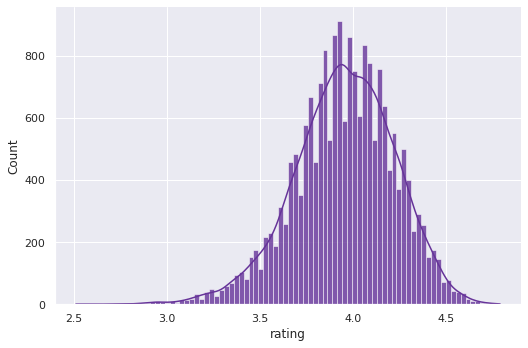

In [132]:
plot_distribution(data,'rating','rebeccapurple',0.8);

In [133]:
def create_corpus(df):
    corpus = []
    for text in df.str.split():
        for i in text:
            corpus.append(i)
    return corpus

In [141]:
from collections import defaultdict

def top_words(catagory):
    df = data[catagory]
    df.dropna(inplace=True)
    corpus = create_corpus(df)
    dic = defaultdict(int)
    for word in corpus:
        if word in es_stop_words:
            dic[word] = 1
        elif word == 'The' or word == "A" or word == "." or word == "," or word == "-":
            dic[word] = 1 
        else:
            dic[word] += 1
            
    top = sorted(dic.items() , key = lambda x:x[1] , reverse = True)[:15]
    plt.figure(figsize = (8,4))
    x , y = zip(*top)
    sns.barplot( x = list(y),y = list(x), palette="Blues_d").set(title = 'Frequency of Top 15')

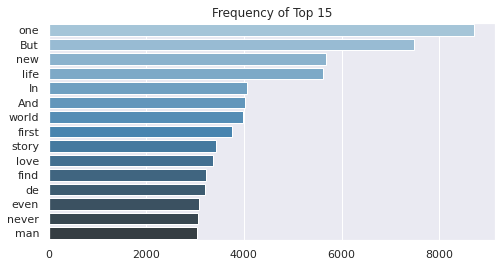

In [144]:
top_words('desc')

# Data Cleaning

In [120]:
data.shape

(19379, 13)

In [121]:
df = data.drop(['img', 'isbn', 'isbn13', 'link', 'reviews', 'totalratings', 'pages', 'bookformat'], axis = 1)

df['text'] = df['author'] + " "+ df['desc'] + " " + df['genre'] + " " +  df['title']

In [122]:
description = df['text'].astype('str') 

In [124]:
import re

# Cleaning Data by removing URLs, ||| and other non alphebatic symobls which will have no impact on model building
text = description.replace('+', ' ').replace('.', " ").replace(',', ' ').replace(':', ' ').replace('"',' ')

# non alpahbets
for index,post in enumerate(text.values):
  text.values[index] = re.sub(r'[^a-zA-Z]', r' ',post)

# removing excess spaces 
for index,post in enumerate(text.values):
  text.values[index] = re.sub(r' +', r' ',post).lower()

text = pd.DataFrame(text)
description = text

In [125]:
lemmatizer = WordNetLemmatizer()
snow_stemmer = SnowballStemmer(language='english')

for idx,temp in enumerate(description):
  token_list = word_tokenize(temp)
  filtered_list = [word for word in token_list if not word in es_stop_words]
  temp = " ".join(filtered_list)

  temp = lemmatizer.lemmatize(temp)
  temp = snow_stemmer.stem(temp)
  description[idx] = temp

In [126]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,confusion_matrix

In [127]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as es
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [128]:
from sklearn import linear_model, metrics
from sklearn.svm import SVR

In [129]:
from sklearn.preprocessing import LabelEncoder

In [130]:
description.reset_index(drop=True)
df.reset_index(drop=True)

,author,desc,genre,rating,title,text
0,Helen Fremont,"""To this day, I don't even know what my mother...","Autobiography,Memoir,Nonfiction,World War II,H...",4.00,After Long Silence,"Helen Fremont ""To this day, I don't even know ..."
1,Christopher Morley,"Roger Mifflin is part pixie, part sage, part n...","Fiction,Writing,Books About Books,Classics,Hum...",4.03,Parnassus on Wheels,Christopher Morley Roger Mifflin is part pixi...
2,Robert J. Shiller,As Robert Shillerâ€™s new 2009 preface to his ...,"Economics,Economics,Finance,Business,Nonfictio...",3.98,Irrational Exuberance,Robert J. Shiller As Robert Shillerâ€™s new 20...
3,"Ovid,David Malouf,James Michie",NaN,"Poetry,Classics,Nonfiction,Philosophy,Romance,...",3.81,The Art of Love,NaN
4,Joseph Staten,"This is how it began...,It is the year 2524. H...","Science Fiction,Fiction,Games,Video Games,Spor...",3.98,Halo: Contact Harvest,"Joseph Staten This is how it began...,It is th..."
...,...,...,...,...,...,...
19374,Robert Jay Lifton,Nazi doctors did more than conduct bizarre exp...,"History,Nonfiction,Psychology,World War II,Hol...",4.10,The Nazi Doctors: Medical Killing and the Psyc...,Robert Jay Lifton Nazi doctors did more than c...
19375,Priscilla Glenn,Ever since the one time Andie Weber threw caut...,"New Adult,Romance,Romance,Contemporary Romance...",3.90,Emancipating Andie,Priscilla Glenn Ever since the one time Andie ...
19376,Roque Larraquy,"La comemadre, ofrece dos relatos que hunden su...","Fiction,Horror,Novella,Novels,Cultural,Latin A...",3.84,La comemadre,"Roque Larraquy La comemadre, ofrece dos relato..."
19377,Melissa Lucashenko,A darkly funny novel of romantic love and cult...,"Fiction,Cultural,Australia,Literary Fiction,Co...",3.93,Mullumbimby,Melissa Lucashenko A darkly funny novel of rom...


# Traing Model

In [ ]:
X = description['text'].astype(str)
y = df["rating"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30,random_state = 0)

X_train = X_train.astype("str")
X_test = X_test.astype("str")
vectorizer = TfidfVectorizer(stop_words = es, lowercase=False)
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

SVR = SVR(kernel = 'rbf')

SVR.fit(X_train_vect,y_train)

y_pred = SVR.predict(X_test_vect)

print(f"\nMAE: {metrics.mean_absolute_error(y_test,y_pred)}")
print(f"\nMSE: {metrics.mean_squared_error(y_test,y_pred)}")
print(f"\nRMSE: {np.sqrt(metrics.mean_squared_error(y_test,y_pred))}")


MAE: 0.17584354128918045

MSE: 0.05039596715604994

RMSE: 0.2244904611694001


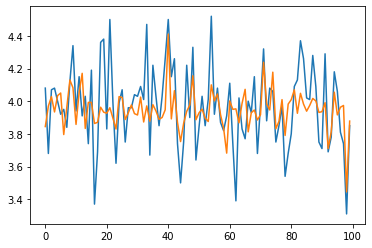

In [ ]:
import matplotlib.pyplot as plt

y_test.reset_index(drop=True, inplace=True)

plt.plot(y_test[0:100])
plt.plot(y_pred[0:100])
plt.show()

# Saving the model

In [ ]:
import pickle

In [ ]:
with open('rating_model_pickle', 'wb') as f:
  pickle.dump(SVR, f)

In [ ]:
with open('rating_model_pickle', 'rb') as f:
  model = pickle.load(f)
  pred = model.predict(vectorizer.transform(['bad man goes on a spritual journy to seek good']))
  print(pred)